<a href="https://www.kaggle.com/code/mohamedbakrey/skin-cancer-detection-by-deep-learning-models?scriptVersionId=114437271" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Step 1: Importing Libraries

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

# Step 2 : Loading pictures and making Dictionary of images and labels

In [3]:
# Train image
train='/kaggle/input/skin-cancer-malignant-vs-benign/train'
# test image
test='/kaggle/input/skin-cancer-malignant-vs-benign/test'

## Work on image

In [4]:
# Here we have two class.
dataset_path_train = os.listdir(train)
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['benign', 'malignant']
Types of classes labels found:  2


In [5]:
# Extract the label  for every image
class_labels = []

for item in dataset_path_train: 
 #
 all_classes = os.listdir(train + '/' +item+'/')
 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))

In [61]:
# Creat DataFrame for image and label
df_train = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
df_train.head()

,Labels,image
0,benign,dataset_path/benign/764.jpg
1,benign,dataset_path/benign/1700.jpg
2,benign,dataset_path/benign/1786.jpg
3,benign,dataset_path/benign/1075.jpg
4,benign,dataset_path/benign/771.jpg


In [7]:
print("Total number of images in the dataset: ", len(df_train))
print("Here we have count of class in kind of image.")
label_count = df_train['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  2637
Here we have count of class in kind of image.
benign       1440
malignant    1197
Name: Labels, dtype: int64


In [8]:
import cv2
path = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
dataset_path = os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign/train/')

im_size =224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   ## Append label names accordingly
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [9]:
## converting python list into numpy array
images = np.array(images)
images = images.astype('float32') / 255.0
print("Shape of Image :", images.shape)

Shape of Image : (2637, 224, 224, 3)


In [10]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df_train['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform(y)

['benign' 'benign' 'benign' ... 'malignant' 'malignant' 'malignant']


In [11]:
y=y.reshape(-1,1)
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()

print("The Lable After convert it to hotencoding:")
print(Y[:5])
print(Y[35:])

The Lable After convert it to hotencoding:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=42)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.1, random_state=42)

#inspect the shape of the training and testing.
print("Shape of X train data:",train_x.shape)
print("Shape of Y train",train_y.shape)

Shape of X train data: (2373, 224, 224, 3)
Shape of Y train (2373, 2)


In [13]:
s1 = np.arange(train_x.shape[0])
np.random.shuffle(s1)
X_train = train_x[s1]
y_train = train_y[s1]

s2 = np.arange(test_x.shape[0])
np.random.shuffle(s2)
X_test = test_x[s2]
y_test = test_y[s2] 

In [14]:
print("Shuffle orders example: ", s1)
print("Shape of train is:",X_train.shape)
print("Shape of train is:",y_train.shape)

Shuffle orders example:  [1559 1010   96 ... 1293 1104 1945]
Shape of train is: (2373, 224, 224, 3)
Shape of train is: (2373, 2)


# Bulding the Model

In [15]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.layers import Flatten, concatenate
from PIL import Image as Img

In [16]:
# Size Of Image
image_size = X_train.shape[1]
print("The Shape of image :",image_size)

The Shape of image : 224


In [17]:
# compute the number of labels
num_labels = len(np.unique(y_train))
print("Number Of Labels:",num_labels)

Number Of Labels: 2


In [18]:
# Network parameters
# Image is processed as is (square grayscale)
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.5

# Creat Model CNN 

In [19]:
# Model is a stack of CNN-ReLU-MaxPooling
model = Sequential()

model.add(Conv2D(filters=filters,kernel_size=kernel_size, activation='relu', input_shape=input_shape))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,kernel_size=kernel_size,activation='relu'))

model.add(Flatten())

# dropout added as regularizer
model.add(Dropout(dropout))
# output layer is 10-dim one-hot vector
model.add(Dense(num_labels))
model.add(Activation('softmax'))


2022-12-21 20:07:18.090964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 20:07:18.192944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 20:07:18.193807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 20:07:18.195039: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dropout (Dropout)            (None, 173056)            0

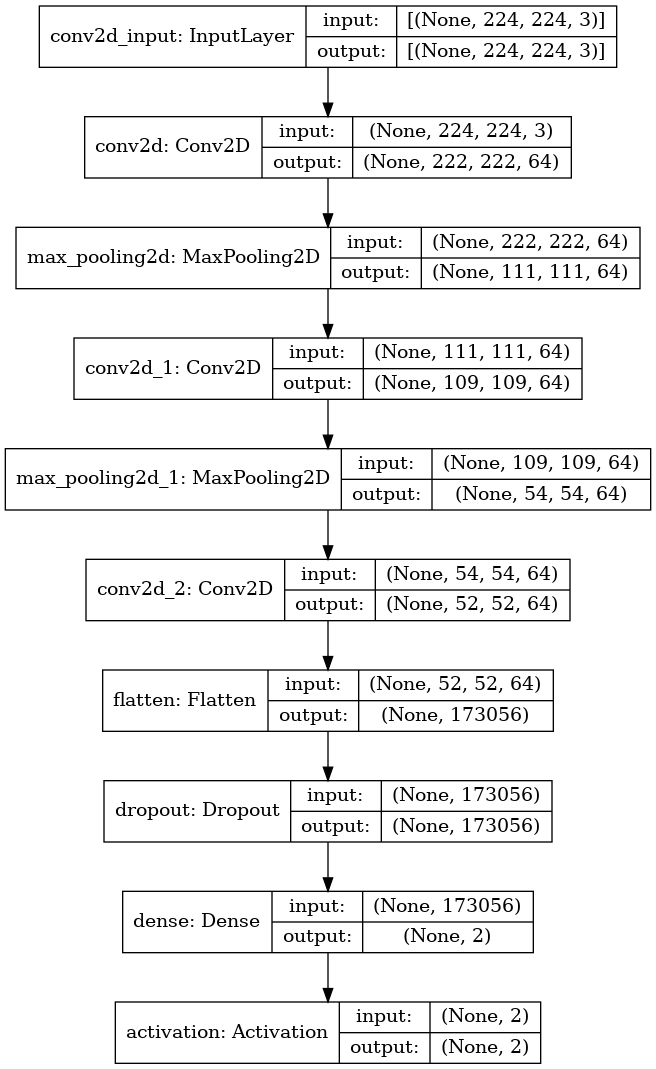

In [21]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-skine Cancer image.png', show_shapes=True)

In [23]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
metrics = ['accuracy', 
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall'),
           F1Score(num_classes = 2,name = 'f1'),
           MatthewsCorrelationCoefficient(num_classes = 2,name='mc'),
           tf.keras.metrics.TruePositives(name= 'tp'),
           tf.keras.metrics.TrueNegatives(name = 'tn'),
           tf.keras.metrics.FalseNegatives(name = 'fn'),
           tf.keras.metrics.FalsePositives(name = 'fp')
          ]

lr=0.001
model.compile(optimizer = Adam(lr = 0.001), loss = "binary_crossentropy", metrics = metrics)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
# train the network
history =model.fit(X_train, y_train, epochs=60, batch_size=batch_size)

2022-12-21 20:07:43.081823: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1428811776 exceeds 10% of free system memory.
2022-12-21 20:07:44.665828: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1428811776 exceeds 10% of free system memory.
2022-12-21 20:07:45.819232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-12-21 20:07:48.980122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


19/19 [==============================] - 14s 186ms/step - loss: 0.8679 - accuracy: 0.5647 - precision: 0.5647 - recall: 0.5647 - f1: 0.5562 - mc: 0.1149 - tp: 1340.0000 - tn: 1340.0000 - fn: 1033.0000 - fp: 1033.0000
Epoch 2/60
19/19 [==============================] - 3s 140ms/step - loss: 0.5829 - accuracy: 0.6827 - precision: 0.6827 - recall: 0.6827 - f1: 0.6767 - mc: 0.3561 - tp: 1620.0000 - tn: 1620.0000 - fn: 753.0000 - fp: 753.0000
Epoch 3/60
19/19 [==============================] - 3s 144ms/step - loss: 0.5206 - accuracy: 0.7244 - precision: 0.7244 - recall: 0.7244 - f1: 0.7229 - mc: 0.4462 - tp: 1719.0000 - tn: 1719.0000 - fn: 654.0000 - fp: 654.0000
Epoch 4/60
19/19 [==============================] - 3s 139ms/step - loss: 0.5099 - accuracy: 0.7396 - precision: 0.7396 - recall: 0.7396 - f1: 0.7373 - mc: 0.4747 - tp: 1755.0000 - tn: 1755.0000 - fn: 618.0000 - fp: 618.0000
Epoch 5/60
19/19 [==============================] - 3s 139ms/step - loss: 0.4534 - accuracy: 0.7678 - precis

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1', 'mc', 'tp', 'tn', 'fn', 'fp'])


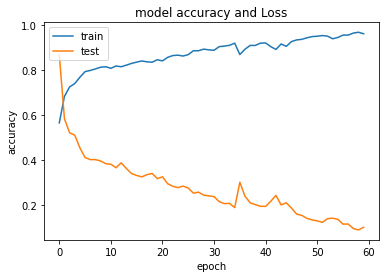

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate The Model

In [26]:
model.evaluate(X_test,y_test)

9/9 [==============================] - 1s 30ms/step - loss: 0.6782 - accuracy: 0.8144 - precision: 0.8144 - recall: 0.8144 - f1: 0.8107 - mc: 0.6243 - tp: 215.0000 - tn: 215.0000 - fn: 49.0000 - fp: 49.0000


[0.6781541705131531,
 0.814393937587738,
 0.814393937587738,
 0.814393937587738,
 array([0.8372093 , 0.78414094], dtype=float32),
 0.624271035194397,
 215.0,
 215.0,
 49.0,
 49.0]

### Save Model

In [27]:
model.save('Model.h5')

## Make Prediction 

In [42]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test,y_test.all())
y_pred = np.argmax(Y_pred, axis=1)

In [56]:
print("The predict lable:",list(y_pred))

The predict lable: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]


##  Predictions on randomly selected test images

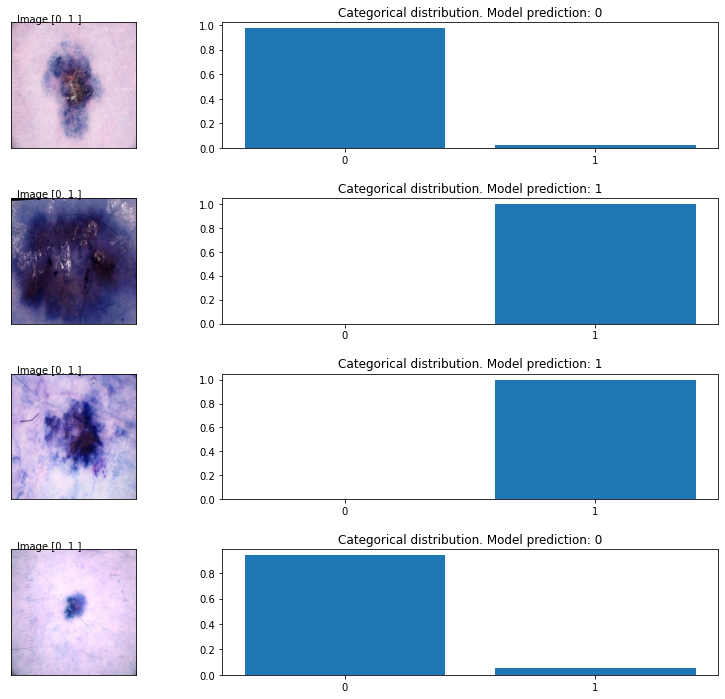

In [60]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images,4)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Image {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()